In [8]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import random
from collections import deque

# Set up the Pendulum environment
env = gym.make('Pendulum-v0')
np.random.seed(42)
tf.random.set_seed(42)
env.seed(42)

# Actor Model
def build_actor(state_shape, action_shape, action_bound):
    inputs = layers.Input(shape=state_shape)
    out = layers.Dense(400, activation="relu")(inputs)
    out = layers.Dense(300, activation="relu")(out)
    outputs = layers.Dense(action_shape[0], activation="tanh")(out)
    outputs = layers.Lambda(lambda i: i * action_bound)(outputs)
    model = models.Model(inputs, outputs)
    return model

# Critic Model
def build_critic(state_shape, action_shape):
    state_input = layers.Input(shape=state_shape)
    action_input = layers.Input(shape=action_shape)
    concat = layers.Concatenate()([state_input, action_input])
    out = layers.Dense(400, activation="relu")(concat)
    out = layers.Dense(300, activation="relu")(out)
    outputs = layers.Dense(1)(out)
    model = models.Model([state_input, action_input], outputs)
    return model

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        sample_batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.asarray, zip(*sample_batch))
        return states, actions, rewards, next_states, dones

# DDPG Agent
class DDPGAgent:
    def __init__(self, state_shape, action_shape, action_bound):
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.action_bound = action_bound
        self.actor = build_actor(state_shape, action_shape, action_bound)
        self.target_actor = build_actor(state_shape, action_shape, action_bound)
        self.critic = build_critic(state_shape, action_shape)
        self.target_critic = build_critic(state_shape, action_shape)
        self.buffer = ReplayBuffer(max_size=20000)
        self.gamma = 0.99
        self.tau = 0.005
        self.actor_optimizer = optimizers.Adam(learning_rate=0.001)
        self.critic_optimizer = optimizers.Adam(learning_rate=0.002)
        self.update_target(self.target_actor, self.actor, 1)
        self.update_target(self.target_critic, self.critic, 1)
    
    def update_target(self, target_model, model, tau):
        for target_param, param in zip(target_model.weights, model.weights):
            target_param.assign(tau * param + (1 - tau) * target_param)
    
    def act(self, state, noise=0.1):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        action = self.actor(state)[0]
        action += noise * np.random.randn(*self.action_shape)
        return np.clip(action, -self.action_bound, self.action_bound)
    
    def train(self, batch_size=64):
        if len(self.buffer.buffer) < batch_size:
            return
        states, actions, rewards, next_states, dones = self.buffer.sample(batch_size)
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)
        
        next_actions = self.target_actor(next_states)
        q_targets = rewards + self.gamma * self.target_critic([next_states, next_actions]) * (1 - dones)
        
        with tf.GradientTape() as tape:
            q_values = self.critic([states, actions])
            critic_loss = tf.reduce_mean(tf.square(q_values - q_targets))
        critic_grads = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))
        
        with tf.GradientTape() as tape:
            actions_pred = self.actor(states)
            actor_loss = -tf.reduce_mean(self.critic([states, actions_pred]))
        actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        
        self.update_target(self.target_actor, self.actor, self.tau)
        self.update_target(self.target_critic, self.critic, self.tau)

# Training the DDPG Agent
state_shape = env.observation_space.shape
action_shape = env.action_space.shape
action_bound = env.action_space.high[0]
agent = DDPGAgent(state_shape, action_shape, action_bound)

episodes = 200
for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.buffer.add(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        total_reward += reward
    print(f'Episode: {episode + 1}, Reward: {total_reward:.2f}')

env.close()


Episode: 1, Reward: -1393.49
Episode: 2, Reward: -1405.85
Episode: 3, Reward: -1474.76
Episode: 4, Reward: -1303.55
Episode: 5, Reward: -1340.56
Episode: 6, Reward: -1376.06
Episode: 7, Reward: -1311.77
Episode: 8, Reward: -1452.76
Episode: 9, Reward: -1385.31
Episode: 10, Reward: -1400.23
Episode: 11, Reward: -1329.91
Episode: 12, Reward: -1349.39
Episode: 13, Reward: -1405.71
Episode: 14, Reward: -1309.05
Episode: 15, Reward: -1286.91
Episode: 16, Reward: -1310.06
Episode: 17, Reward: -1320.78
Episode: 18, Reward: -1370.91
Episode: 19, Reward: -1343.54
Episode: 20, Reward: -1361.57
Episode: 21, Reward: -1261.37
Episode: 22, Reward: -1370.26
Episode: 23, Reward: -1328.26
Episode: 24, Reward: -1193.49
Episode: 25, Reward: -1327.11
Episode: 26, Reward: -1343.06
Episode: 27, Reward: -1413.99
Episode: 28, Reward: -1325.84
Episode: 29, Reward: -1355.17
Episode: 30, Reward: -1628.44
Episode: 31, Reward: -1340.01
Episode: 32, Reward: -1344.74
Episode: 33, Reward: -1381.69
Episode: 34, Reward

KeyboardInterrupt: 

In [4]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up the Pendulum environment
env = gym.make('Pendulum-v0')
np.random.seed(42)
tf.random.set_seed(42)
env.seed(42)

# Actor Model
def build_actor(state_shape, action_shape, action_bound):
    inputs = layers.Input(shape=state_shape)
    out = layers.Dense(400, activation="relu")(inputs)
    out = layers.Dense(300, activation="relu")(out)
    outputs = layers.Dense(action_shape[0], activation="tanh")(out)
    outputs = layers.Lambda(lambda i: i * action_bound)(outputs)
    model = models.Model(inputs, outputs)
    return model

# Critic Model
def build_critic(state_shape, action_shape):
    state_input = layers.Input(shape=state_shape)
    action_input = layers.Input(shape=action_shape)
    concat = layers.Concatenate()([state_input, action_input])
    out = layers.Dense(400, activation="relu")(concat)
    out = layers.Dense(300, activation="relu")(out)
    outputs = layers.Dense(1)(out)
    model = models.Model([state_input, action_input], outputs)
    return model

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        sample_batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.asarray, zip(*sample_batch))
        return states, actions, rewards, next_states, dones

# DDPG Agent
class DDPGAgent:
    def __init__(self, state_shape, action_shape, action_bound):
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.action_bound = action_bound
        self.actor = build_actor(state_shape, action_shape, action_bound)
        self.target_actor = build_actor(state_shape, action_shape, action_bound)
        self.critic = build_critic(state_shape, action_shape)
        self.target_critic = build_critic(state_shape, action_shape)
        self.buffer = ReplayBuffer(max_size=20000)
        self.gamma = 0.99
        self.tau = 0.005
        self.actor_optimizer = optimizers.Adam(learning_rate=0.001)
        self.critic_optimizer = optimizers.Adam(learning_rate=0.002)
        self.update_target(self.target_actor, self.actor, 1)
        self.update_target(self.target_critic, self.critic, 1)
    
    def update_target(self, target_model, model, tau):
        for target_param, param in zip(target_model.weights, model.weights):
            target_param.assign(tau * param + (1 - tau) * target_param)
    
    def act(self, state, noise=0.1):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        action = self.actor(state)[0]
        action += noise * np.random.randn(*self.action_shape)
        return np.clip(action, -self.action_bound, self.action_bound)
    
    def train(self, batch_size=64):
        if len(self.buffer.buffer) < batch_size:
            return
        states, actions, rewards, next_states, dones = self.buffer.sample(batch_size)
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)
        
        next_actions = self.target_actor(next_states)
        q_targets = rewards + self.gamma * self.target_critic([next_states, next_actions]) * (1 - dones)
        
        with tf.GradientTape() as tape:
            q_values = self.critic([states, actions])
            critic_loss = tf.reduce_mean(tf.square(q_values - q_targets))
        critic_grads = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))
        
        with tf.GradientTape() as tape:
            actions_pred = self.actor(states)
            actor_loss = -tf.reduce_mean(self.critic([states, actions_pred]))
        actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        
        self.update_target(self.target_actor, self.actor, self.tau)
        self.update_target(self.target_critic, self.critic, self.tau)

# Training the DDPG Agent
state_shape = env.observation_space.shape
action_shape = env.action_space.shape
action_bound = env.action_space.high[0]
agent = DDPGAgent(state_shape, action_shape, action_bound)

episodes = 200
rewards_history = []
for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.buffer.add(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        total_reward += reward
    rewards_history.append(total_reward)
    print(f'Episode: {episode + 1}, Reward: {total_reward:.2f}')

env.close()

# Plotting the rewards
plt.plot(rewards_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DDPG on Pendulum-v0')
plt.show()


Episode: 1, Reward: -1413.89
Episode: 2, Reward: -1280.21
Episode: 3, Reward: -1178.71
Episode: 4, Reward: -1298.68
Episode: 5, Reward: -1307.34
Episode: 6, Reward: -1039.80
Episode: 7, Reward: -1338.40
Episode: 8, Reward: -1338.27
Episode: 9, Reward: -1338.47
Episode: 10, Reward: -1416.18
Episode: 11, Reward: -1117.90
Episode: 12, Reward: -1266.72
Episode: 13, Reward: -1853.23
Episode: 14, Reward: -1607.23
Episode: 15, Reward: -1303.04
Episode: 16, Reward: -1279.97
Episode: 17, Reward: -1594.39
Episode: 18, Reward: -1468.37
Episode: 19, Reward: -1265.03
Episode: 20, Reward: -1430.71
Episode: 21, Reward: -1219.67
Episode: 22, Reward: -1520.46
Episode: 23, Reward: -1199.87
Episode: 24, Reward: -1160.91
Episode: 25, Reward: -1182.10
Episode: 26, Reward: -1603.28
Episode: 27, Reward: -1535.26
Episode: 28, Reward: -1358.27
Episode: 29, Reward: -1240.73
Episode: 30, Reward: -1826.52
Episode: 31, Reward: -1103.41
Episode: 32, Reward: -928.38
Episode: 33, Reward: -1819.81
Episode: 34, Reward:

Episode: 1, Reward: -1252.34
New best reward: -1252.34, saving weights.
Episode: 2, Reward: -1636.45
Episode: 3, Reward: -1180.05
New best reward: -1180.05, saving weights.
Episode: 4, Reward: -1340.35
Episode: 5, Reward: -1321.32
Episode: 6, Reward: -1154.20
New best reward: -1154.20, saving weights.
Episode: 7, Reward: -1244.30
Episode: 8, Reward: -1171.43
Episode: 9, Reward: -1010.01
New best reward: -1010.01, saving weights.
Episode: 10, Reward: -1485.78
Episode: 11, Reward: -1584.98
Episode: 12, Reward: -1616.57
Episode: 13, Reward: -1815.47
Episode: 14, Reward: -1533.62
Episode: 15, Reward: -1182.53
Episode: 16, Reward: -970.27
New best reward: -970.27, saving weights.
Episode: 17, Reward: -1533.13
Episode: 18, Reward: -1670.47
Episode: 19, Reward: -1451.12
Episode: 20, Reward: -1727.36
Episode: 21, Reward: -1325.08
Episode: 22, Reward: -1515.17
Episode: 23, Reward: -1234.63
Episode: 24, Reward: -1169.99
Episode: 25, Reward: -1185.41
Episode: 26, Reward: -1744.08
Episode: 27, Rew

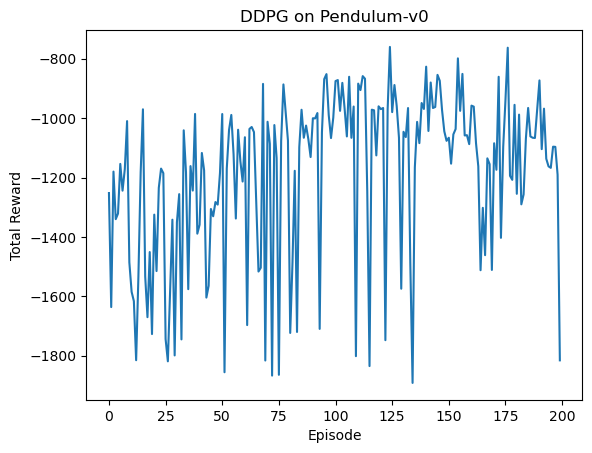

In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import random
from collections import deque
import matplotlib.pyplot as plt
import os

# Set up the Pendulum environment
env = gym.make('Pendulum-v0')
np.random.seed(42)
tf.random.set_seed(42)
env.seed(42)

# Actor Model
def build_actor(state_shape, action_shape, action_bound):
    inputs = layers.Input(shape=state_shape)
    out = layers.Dense(400, activation="relu")(inputs)
    out = layers.Dense(300, activation="relu")(out)
    outputs = layers.Dense(action_shape[0], activation="tanh")(out)
    outputs = layers.Lambda(lambda i: i * action_bound)(outputs)
    model = models.Model(inputs, outputs)
    return model

# Critic Model
def build_critic(state_shape, action_shape):
    state_input = layers.Input(shape=state_shape)
    action_input = layers.Input(shape=action_shape)
    concat = layers.Concatenate()([state_input, action_input])
    out = layers.Dense(400, activation="relu")(concat)
    out = layers.Dense(300, activation="relu")(out)
    outputs = layers.Dense(1)(out)
    model = models.Model([state_input, action_input], outputs)
    return model

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        sample_batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.asarray, zip(*sample_batch))
        return states, actions, rewards, next_states, dones

# DDPG Agent
class DDPGAgent:
    def __init__(self, state_shape, action_shape, action_bound):
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.action_bound = action_bound
        self.actor = build_actor(state_shape, action_shape, action_bound)
        self.target_actor = build_actor(state_shape, action_shape, action_bound)
        self.critic = build_critic(state_shape, action_shape)
        self.target_critic = build_critic(state_shape, action_shape)
        self.buffer = ReplayBuffer(max_size=20000)
        self.gamma = 0.99
        self.tau = 0.005
        self.actor_optimizer = optimizers.Adam(learning_rate=0.001)
        self.critic_optimizer = optimizers.Adam(learning_rate=0.002)
        self.update_target(self.target_actor, self.actor, 1)
        self.update_target(self.target_critic, self.critic, 1)
    
    def update_target(self, target_model, model, tau):
        for target_param, param in zip(target_model.weights, model.weights):
            target_param.assign(tau * param + (1 - tau) * target_param)
    
    def act(self, state, noise=0.1):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        action = self.actor(state)[0]
        action += noise * np.random.randn(*self.action_shape)
        return np.clip(action, -self.action_bound, self.action_bound)
    
    def train(self, batch_size=64):
        if len(self.buffer.buffer) < batch_size:
            return
        states, actions, rewards, next_states, dones = self.buffer.sample(batch_size)
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)
        
        next_actions = self.target_actor(next_states)
        q_targets = rewards + self.gamma * self.target_critic([next_states, next_actions]) * (1 - dones)
        
        with tf.GradientTape() as tape:
            q_values = self.critic([states, actions])
            critic_loss = tf.reduce_mean(tf.square(q_values - q_targets))
        critic_grads = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))
        
        with tf.GradientTape() as tape:
            actions_pred = self.actor(states)
            actor_loss = -tf.reduce_mean(self.critic([states, actions_pred]))
        actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        
        self.update_target(self.target_actor, self.actor, self.tau)
        self.update_target(self.target_critic, self.critic, self.tau)

# Training the DDPG Agent
state_shape = env.observation_space.shape
action_shape = env.action_space.shape
action_bound = env.action_space.high[0]
agent = DDPGAgent(state_shape, action_shape, action_bound)

episodes = 200
rewards_history = []
best_reward = -np.inf
save_path = './best_weights'

if not os.path.exists(save_path):
    os.makedirs(save_path)

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.buffer.add(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        total_reward += reward
    rewards_history.append(total_reward)
    print(f'Episode: {episode + 1}, Reward: {total_reward:.2f}')

    # Save the best weights
    if total_reward > best_reward:
        best_reward = total_reward
        agent.actor.save_weights(f'{save_path}/actor.h5')
        agent.critic.save_weights(f'{save_path}/critic.h5')
        agent.target_actor.save_weights(f'{save_path}/target_actor.h5')
        agent.target_critic.save_weights(f'{save_path}/target_critic.h5')
        print(f'New best reward: {best_reward:.2f}, saving weights.')

env.close()

# Plotting the rewards
plt.plot(rewards_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DDPG on Pendulum-v0')
plt.show()


In [5]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from collections import deque
import random

# Initialize the Pendulum-v0 environment
env = gym.make('Pendulum-v0')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
env.seed(42)

# Define the DQN model
def build_model(state_size, action_size):
    model = models.Sequential()
    model.add(layers.Dense(24, input_dim=state_size, activation='relu'))
    model.add(layers.Dense(24, activation='relu'))
    model.add(layers.Dense(action_size, activation='linear'))
    model.compile(loss='mse', optimizer=optimizers.Adam(lr=0.001))
    return model

# DQN Agent class
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = build_model(state_size, action_size)
        self.target_model = build_model(state_size, action_size)
        self.update_target_model()

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                t = self.target_model.predict(next_state)[0]
                target[0][action] = reward + self.gamma * np.amax(t)
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

# Hyperparameters
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
agent = DQNAgent(state_size, action_size)
done = False
batch_size = 32

# Train the model
for e in range(1000):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    for time in range(500):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            agent.update_target_model()
            print(f"episode: {e}/{1000}, score: {time}, e: {agent.epsilon:.2}")
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

# Save the trained model
agent.save("dqn_pendulum.h5")

# Evaluate the model
for e in range(10):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    for time in range(500):
        env.render()
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        state = next_state
        if done:
            print(f"episode: {e}/{10}, score: {time}")
            break

env.close()


IndexError: invalid index to scalar variable.